In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import re
import string
import umap
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import v_measure_score, davies_bouldin_score, make_scorer, f1_score
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from scipy.spatial.distance import jensenshannon

In [4]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Preprocesses the given text by lowercasing, removing punctuation, 
    tokenizing, removing stopwords, and lemmatizing."""
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  
    text = re.sub(r"\s+", " ", text)  
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

def load_bbc_news():
    """Loads the BBC News dataset."""
    DATASET_TRAIN = r"C:\\Users\\Debbertin\\Downloads\\BBC News Train.csv"
    DATASET_TEST = r"C:\\Users\\Debbertin\\Downloads\\BBC News Test.csv"
    df_train = pd.read_csv(DATASET_TRAIN)
    df_test = pd.read_csv(DATASET_TEST)
    return df_train, df_test

# Load the BBC News dataset
df_train, df_test = load_bbc_news()

# Extract text data
train_data = df_train['Text'].tolist()
test_data = df_test['Text'].tolist()

# Preprocess the dataset
preprocessed_train_data = [preprocess_text(doc) for doc in train_data]
preprocessed_test_data = [preprocess_text(doc) for doc in test_data]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Debbertin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Debbertin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Debbertin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Set true labels
true_labels = df_train['Category'].astype('category').cat.codes.values  # Also Converting categorical labels to numeric codes

print(true_labels)

[0 0 0 ... 0 4 4]


In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Light Weight SBERT-Model
embeddings = model.encode(preprocessed_train_data)  
embeddings_test = model.encode(preprocessed_test_data)

In [ ]:
# Normalize Embeddings
embeddings = normalize(embeddings)
embeddings_test = normalize(embeddings_test)

Explained Variance Ratio for each component: [0.06692966 0.05889386 0.04204642 0.0313381  0.02968825 0.02621159
 0.02213738 0.01888751 0.01766251 0.01644138 0.01515393 0.01377789
 0.01364837 0.0129139  0.01247883 0.01198938 0.01159036 0.01075743
 0.01036504 0.0099716  0.00991034 0.00945157 0.00931994 0.00883856
 0.00858825 0.00844215 0.00809267 0.00802749 0.00779388 0.00769575
 0.00743287 0.00714223 0.00693551 0.00674179 0.00666576 0.00650377
 0.00632055 0.00623207 0.00616862 0.00594091 0.00591539 0.00574424
 0.00566967 0.00555256 0.00552162 0.00538528 0.00533011 0.00518209
 0.00513527 0.00496131 0.00490712 0.0048423  0.00478702 0.00470941
 0.00454992 0.00448212 0.00444707 0.00436415 0.00433009 0.00420994
 0.00410678 0.0040555  0.00398557 0.00394886 0.00380603 0.00376608
 0.00371741 0.00368072 0.00363951 0.00351294 0.00349247 0.00345865
 0.00340313 0.00333577 0.00325619 0.00323634 0.00319015 0.00314115
 0.00311479 0.00307186 0.00304224 0.00298882 0.00296739 0.00289602
 0.00288237 0.002

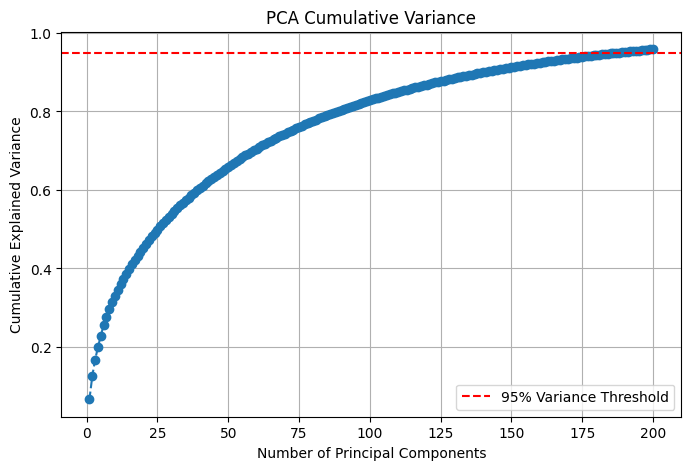

In [ ]:
# Reducing Dimensionality through PCA
pca = PCA(n_components=200)
X_pca = pca.fit_transform(embeddings)

# Explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print results
print("Explained Variance Ratio for each component:", explained_variance_ratio)
print("Cumulative Variance:", cumulative_variance)
print(f"Total variance retained: {cumulative_variance[-1] * 100:.2f}%")

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid()
plt.show()

Explained Variance Ratio for each component: [0.06942634 0.06179674 0.04064558 0.03180171 0.02913802 0.0253725
 0.02177643 0.01838597 0.01809395 0.01675345 0.01604205 0.01475207
 0.01403343 0.01387982 0.01320214 0.01242999 0.01179789 0.01145015
 0.01098931 0.01051763 0.01021436 0.00974088 0.00962229 0.00918878
 0.00905275 0.00876845 0.00854129 0.00836659 0.00812116 0.00788152
 0.00773875 0.00760044 0.00722698 0.00716294 0.00706974 0.00682077
 0.00668199 0.00661564 0.00655645 0.0064615  0.00628636 0.00611936
 0.00601748 0.0058986  0.00568444 0.0056348  0.00551709 0.00533575
 0.00524021 0.00515991 0.00507316 0.00491519 0.00483759 0.00478781
 0.00472054 0.00466828 0.00455635 0.00446796 0.00436491 0.00434425
 0.00420375 0.00418895 0.00404909 0.00399897 0.00391078 0.00381712
 0.00373862 0.00366854 0.00363553 0.00359839 0.00349389 0.00343669
 0.00338944 0.0033266  0.00327777 0.00321286 0.00320028 0.00316598
 0.00309672 0.00307387 0.00302078 0.00296901 0.0028759  0.00285352
 0.00284379 0.0028

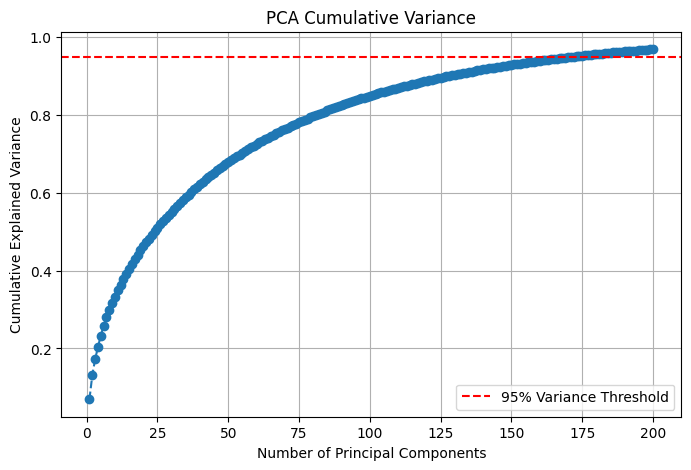

In [9]:
# Reducing Dimensionality through PCA
pca_test = PCA(n_components=200)
X_pca_test = pca_test.fit_transform(embeddings_test)

# Explained variance ratio for each component
explained_variance_ratio_test = pca_test.explained_variance_ratio_
cumulative_variance_test = np.cumsum(explained_variance_ratio_test)

# Print results
print("Explained Variance Ratio for each component:", explained_variance_ratio_test)
print("Cumulative Variance:", cumulative_variance_test)
print(f"Total variance retained: {cumulative_variance_test[-1] * 100:.2f}%")

# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance_test) + 1), cumulative_variance_test, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Creating a cosine similarity Matrix
cosine_similarity_matrix = cosine_similarity(X_pca)
# Check for NaN
print(f"Does Similarity Matrix contain NaN-Values? {np.isnan(cosine_similarity_matrix).any()}")

Does Similarity Matrix contain NaN-Values? False


In [39]:
print(f"Shape of Embeddings: {embeddings.shape}")
print(f"Shape of PCA Embeddings: {X_pca.shape}")

Shape of Embeddings: (1490, 384)
Shape of PCA Embeddings: (1490, 200)


In [12]:
print(f"Minimum Value: {np.min(embeddings)}, Maximum Value: {np.max(embeddings)}")

Minimum Value: -0.22878293693065643, Maximum Value: 0.22340473532676697


In [13]:
norms = np.linalg.norm(embeddings, axis=1)
print(f"Minimal Norm: {np.min(norms)}")

Minimal Norm: 0.9999998807907104


In [14]:
row_sums = np.sum(cosine_similarity_matrix, axis=1)
print("Rows with zero sums (isolated nodes):", np.where(row_sums == 0)[0])

Rows with zero sums (isolated nodes): []


In [15]:
print("Matrix symmetric:", np.allclose(cosine_similarity_matrix, cosine_similarity_matrix.T))
print("Matrix non-negative:", np.all(cosine_similarity_matrix >= 0))
print("Diagonal values:", np.diag(cosine_similarity_matrix))

Matrix symmetric: True
Matrix non-negative: False
Diagonal values: [0.99999976 0.9999998  0.99999994 ... 0.9999998  0.99999964 1.0000001 ]


In [16]:
np.fill_diagonal(cosine_similarity_matrix, 1)
print("Diagonal values:", np.diag(cosine_similarity_matrix))

Diagonal values: [1. 1. 1. ... 1. 1. 1.]


In [17]:
print(f"Minimum Value: {np.min(cosine_similarity_matrix)}, Maximum Value: {np.max(cosine_similarity_matrix)}")

Minimum Value: -0.4085879325866699, Maximum Value: 1.0000005960464478


In [18]:
# Initializing Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize Cosine Similarity Matrix
normalized_matrix = scaler.fit_transform(cosine_similarity_matrix)

In [19]:
print(f"Minimum Value: {np.min(normalized_matrix)}, Maximum Value: {np.max(normalized_matrix)}")

Minimum Value: 0.0, Maximum Value: 1.0000001192092896


In [20]:
normalized_matrix[normalized_matrix > 1] = 1

In [21]:
print(f"Minimum Value: {np.min(normalized_matrix)}, Maximum Value: {np.max(normalized_matrix)}")

Minimum Value: 0.0, Maximum Value: 1.0


In [22]:
# Spectral Clustering using the cosine similarity matrix
n_clusters = 5
spectral_model = SpectralClustering(
    n_clusters=n_clusters,   
    affinity='precomputed',  
    random_state=42
)

# Fit and predict cluster labels
cluster_labels = spectral_model.fit_predict(normalized_matrix)

# Output the cluster labels
print("Cluster Labels:", cluster_labels)

c:\Users\Debbertin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Cluster Labels: [0 3 3 ... 3 0 0]


In [23]:
#Calculate V-Measure Score:
v_measure = v_measure_score(true_labels, cluster_labels)
print("V-Measure:", v_measure)

V-Measure: 0.7258108934165792


In [25]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=70, max_iter=1000)
X_train_tsne = tsne.fit_transform(X_pca)
X_test_tsne = tsne.fit_transform(X_pca_test)

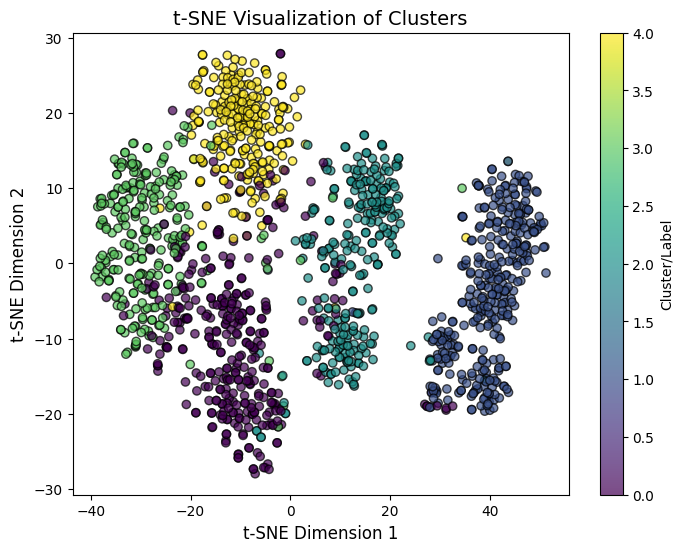

In [26]:
# Scatter plot with labels from spectral clustering
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_tsne[:, 0], X_train_tsne[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.7, edgecolor='k'
)

# Add colorbar
plt.colorbar(scatter, label='Cluster/Label')

# Add titles and labels
plt.title("t-SNE Visualization of Clusters", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

plt.show()

c:\Users\Debbertin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Debbertin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Debbertin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


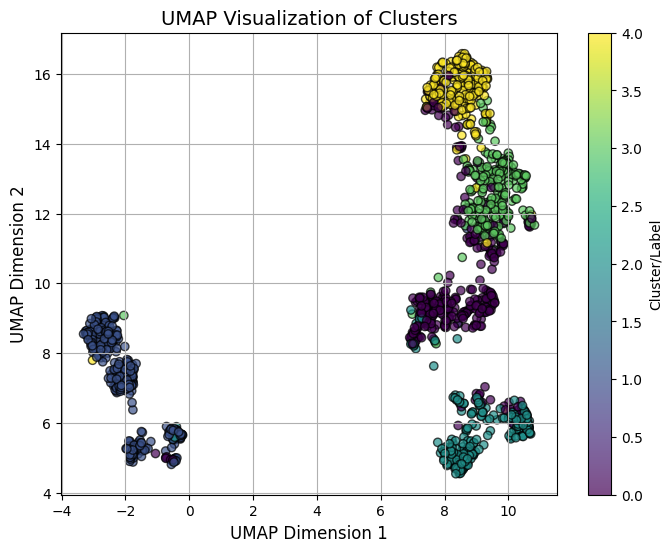

In [27]:
# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=40, min_dist=0.1, metric="euclidean", n_components=2, random_state=42)
X_umap_Train = umap_model.fit_transform(X_pca)
X_umap_Test = umap_model.fit_transform(X_pca_test)

# Visualize UMAP clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_umap_Train[:, 0], X_umap_Train[:, 1],
    c=cluster_labels, cmap='viridis', alpha=0.7, edgecolor='k'
)

# Add colorbar
plt.colorbar(scatter, label='Cluster/Label')

# Add titles and labels
plt.title("UMAP Visualization of Clusters", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

plt.grid()
plt.show()

In [28]:
# Train Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_pca, true_labels)

SVC(random_state=42)

In [29]:
#Classfication of Test Data
y_pred = svm_model.predict(X_pca_test)

In [40]:
# Perform cross-validation on the training set
f1_scorer = make_scorer(f1_score, average='weighted')
cv_scores = cross_val_score(svm_model, X_pca, cluster_labels, cv=5, scoring=f1_scorer)

print(f"F1 Scores from Cross-Validation: {cv_scores}")
print(f"Average F1 Score: {cv_scores.mean():.3f}")

F1 Scores from Cross-Validation: [0.94940214 0.95947006 0.93966492 0.93191006 0.94965163]
Average F1 Score: 0.946


In [31]:
# Initializing the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Training on training data
rf_model.fit(X_pca, true_labels)

# Predicting on test data
y_pred_rf = rf_model.predict(X_pca_test)

# Cross-validation for F1 score on training data
f1_scores = cross_val_score(rf_model, X_pca, cluster_labels, cv=5, scoring='f1_weighted')

# Print results
print(f"Cross-Validation F1 Scores: {f1_scores}")
print(f"Average F1 Score: {f1_scores.mean():.3f}")

Cross-Validation F1 Scores: [0.95288061 0.9429761  0.94316248 0.93941849 0.93965052]
Average F1 Score: 0.944
